In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from model import RedCNN
from customDataset import CatdogDataset
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

from PIL import Image
from IPython.display import display
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
gtpath="../dogData_20/gt/"
gtfiles=[]
for folder, subfolder, filenames in os.walk(gtpath):
    for files in filenames:
        gtfiles.append(files)
        

noisepath="../dogData_20/noise/"
noisefiles=[]
for folder, subfolder, filenames in os.walk(noisepath):
    for files in filenames:
        noisefiles.append(files)
        
#check whether both noise and gt have same files
print(gtfiles==noisefiles)

#Due to computational limitation, I only take 200 images
gtfiles_=gtfiles[:1000]

True


In [3]:
m1dataset= CatdogDataset(data_path=noisepath,target_path=gtpath,filenames=gtfiles_)
train_size=int(0.8*len(m1dataset))
test_size=len(m1dataset)-train_size
trainset,testset=random_split(m1dataset,[train_size,test_size],generator=torch.manual_seed(42))


In [4]:
model=RedCNN()
print(model)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_conv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (d_output): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [5]:
##Training
optimizer.zero_grad()

train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=True)


losses_batch=[]
trained_psnr=[]
psnr=[]
for epoch in range(2):
    
    for i, data in enumerate(train_loader):

        inputt, target=data

        target_pred=model(inputt)

        img=inputt.detach().numpy()
        img_gt=target.detach().numpy()
        recon_image=target_pred.detach().numpy()
        
        
        for j in range(len(target)):
            psnr.append(cv2.PSNR(img[j],img_gt[j]))
            trained_psnr.append(cv2.PSNR(img[j],recon_image[j]))

        loss=criterion(target_pred,target)
        losses_batch.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch: {epoch} Loss:{loss.item()} Batch:{i}")




Epoch: 0 Loss:474.5618591308594 Batch:0
Epoch: 0 Loss:427.8575744628906 Batch:1
Epoch: 0 Loss:365.4355163574219 Batch:2
Epoch: 0 Loss:324.2440490722656 Batch:3
Epoch: 0 Loss:288.0024108886719 Batch:4
Epoch: 0 Loss:251.57009887695312 Batch:5
Epoch: 0 Loss:223.96571350097656 Batch:6
Epoch: 0 Loss:186.98243713378906 Batch:7
Epoch: 0 Loss:167.2623748779297 Batch:8
Epoch: 0 Loss:162.0356903076172 Batch:9
Epoch: 0 Loss:150.449462890625 Batch:10
Epoch: 0 Loss:122.57096099853516 Batch:11
Epoch: 0 Loss:112.82666778564453 Batch:12
Epoch: 0 Loss:122.04739379882812 Batch:13


KeyboardInterrupt: 

In [6]:
fisher_dict={}
param_dict={}
            
for name, param in model.named_parameters():
    
    param_dict[name] = param.data.clone()
        
    fisher_dict[name] = param.grad.data.clone().pow(2)

param_dictfile="./saved_fisherinfo/task1_param_dict.pth.tar"
fisher_dictfile="./saved_fisherinfo/task1_fisher_dict.pth.tar"
trained_psnrfile="./psnr_data/task1_by_task1_trainfiles.pth.tar"
psnr_file="./psnr_data/task1_trainfiles.pth.tar"

torch.save(fisher_dict,fisher_dictfile)
torch.save(param_dict,param_dictfile)
torch.save(trained_psnr,trained_psnrfile)
torch.save(psnr,psnr_file)
modelfile="./saved_models/task1_model.pth.tar"

torch.save(model.state_dict(),modelfile)

In [7]:
print(f"PSNR train set: {sum(psnr)/len(psnr)}")
print(f"PSNR after model: {sum(trained_psnr)/len(trained_psnr)}")

PSNR train set: 21.56917310448305
PSNR after model: 28.970873793352467


In [ ]:
model.eval()
gt_psnr=[]
train_psnr=[]
for i in range(len(testset)):
    noise,gt=testset[i]
    gt_psnr.append(cv2.PSNR(noise.numpy(),gt.numpy()))
    train_psnr.append(cv2.PSNR(model(noise.view(-1,1,224,224)).detach().numpy().reshape(1,224,224),gt.numpy()))
    
print(f"PSNR test set: {sum(gt_psnr)/len(gt_psnr)}")
print(f"PSNR after model: {sum(train_psnr)/len(train_psnr)}")

torch.save(gt_psnr,"./psnr_data/task1_testfiles.pth.tar")
torch.save(train_psnr,"./psnr_data/task1_by_task1_testfiles.pth.tar")

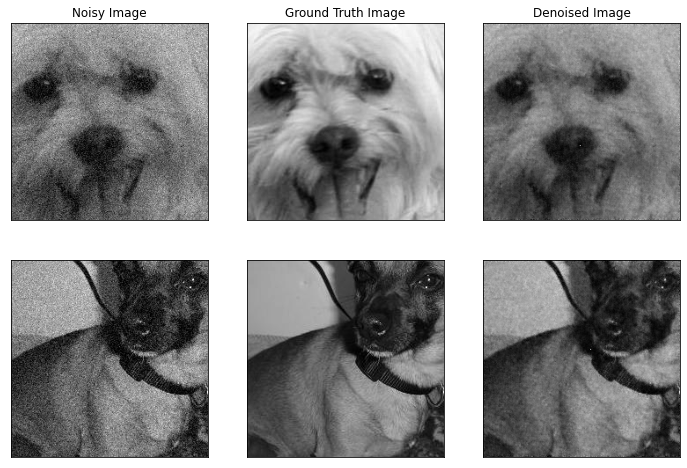

In [8]:
##Visualize the result with the image

input_image,target_image=trainset[100]

input_image=input_image.view(-1,1,224,224)
target_image=target_image.view(-1,1,224,224)

input_image2,target_image2=testset[9]
input_image2=input_image2.view(-1,1,224,224)
target_image2=target_image2.view(-1,1,224,224)
with torch.no_grad():
    netoutput_image=model(input_image)
    netoutput_image2=model(input_image2)

    

fig, ax = plt.subplots(2, 3,figsize=(12, 8))


ax[0][0].imshow(np.transpose(input_image.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")
ax[0][1].imshow(np.transpose(target_image.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")
ax[0][2].imshow(np.transpose(netoutput_image.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")

ax[1][0].imshow(np.transpose(input_image2.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")
ax[1][1].imshow(np.transpose(target_image2.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")
ax[1][2].imshow(np.transpose(netoutput_image2.view(1,224,224).to(torch.uint8),(1,2,0)),cmap="gray")

# Add titles to each subplot
ax[0][0].set_title('Noisy Image')
ax[0][1].set_title('Ground Truth Image')
ax[0][2].set_title('Denoised Image')

# # Remove the x and y ticks
for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

# Show the plot
plt.show()

